# Setup

In [1]:
!pip install -U pymfe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.4 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
%config InlineBackend.figure_format = 'retina'

In [10]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 25
BATCH_IMAGE_INDEX = 0
SIZE_LOOP_TO_HOOK = 1


IMG_SIZE = 32
N_CLASSES = 10

# Funções auxiliares

In [12]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

def get_accuracy_with_hooks(model, data_loader, intermediateRepresentationsMapTensor, ty, device,hook_layers=True):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0
    # tys = []
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)
            ty = torch.cat((ty,y_true[BATCH_IMAGE_INDEX].reshape(1)),0)
            # tys.append(y_true[0])

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            if hook_layers:
              for _, (layerName, layer) in enumerate(model.named_children()):
                # print(activation[layerName].size())
                # print(activation[layerName][0].size())
                if layerName in intermediateRepresentationsMapTensor:
                  t = intermediateRepresentationsMapTensor[layerName]
                  # t = torch.cat((t,activation[layerName]),0)
                  t = torch.cat((t,torch.unsqueeze(activation[layerName][BATCH_IMAGE_INDEX],0)),0)
                  # print(t.size())
                  intermediateRepresentationsMapTensor[layerName] = t
                else:
                  intermediateRepresentationsMapTensor[layerName] = torch.unsqueeze(activation[layerName][BATCH_IMAGE_INDEX],0)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()


    return (correct_pred.float() / n, ty)

def training_loop_with_hooks(model, criterion, optimizer, train_loader, valid_loader, epochs, device, hook_every=1,hook_layers=True):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracy = pd.DataFrame(columns=['epoch','value'])
    valid_accuracy = pd.DataFrame(columns=['epoch','value'])

    testCompTable = pd.DataFrame(columns=['epoch','layer','metric','value'])
    trainCompTable = pd.DataFrame(columns=['epoch','layer','metric','value'])


    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if (epoch % hook_every == (hook_every - 1)):

            if(hook_layers):
              hooks = attach_hooks(model)
            ty = torch.Tensor().to(DEVICE)
            intermediateRepresentationsMapTensor = {}
            train_acc, ty = get_accuracy_with_hooks(model, train_loader, intermediateRepresentationsMapTensor, ty, device=device,hook_layers=hook_layers)
            # print(ty)
            # print(intermediateRepresentationsMapTensor)
            entry = {"epoch": epoch, "value": train_acc.to('cpu').numpy()}
            entryDf = pd.DataFrame(entry, index=[0])
            train_accuracy = pd.concat([train_accuracy,entryDf],ignore_index=True)
            trainCompTable = complexity_calculator(trainCompTable,intermediateRepresentationsMapTensor,ty,epoch)


            ty = torch.Tensor().to(DEVICE)
            intermediateRepresentationsMapTensor = {}
            valid_acc, ty = get_accuracy_with_hooks(model, valid_loader, intermediateRepresentationsMapTensor, ty, device=device,hook_layers=hook_layers)
            entry = {"epoch": epoch, "value": valid_acc.to('cpu').numpy()}
            entryDf = pd.DataFrame(entry, index=[0])
            valid_accuracy = pd.concat([valid_accuracy,entryDf],ignore_index=True)
            testCompTable = complexity_calculator(testCompTable,intermediateRepresentationsMapTensor,ty,epoch)

            if(hook_layers):
              remove_hooks(hooks)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses), (trainCompTable,testCompTable), (train_accuracy, valid_accuracy)

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def attach_hooks(model):
  hooks = []
  for idx, (layerName, layer) in enumerate(model.named_children()):
    hooks.append(layer.register_forward_hook(getActivation(layerName)))
  return hooks

def remove_hooks(hooks):
  for h in hooks:
    h.remove()

def complexity_calculator(DataMap,intermediateRepresentationsMapTensor,ty,epoch):
  for layerName in intermediateRepresentationsMapTensor.keys():
    intermediateRepresentationsTensor = intermediateRepresentationsMapTensor[layerName]
    complexitiesMap = complexity_calculator_layer(intermediateRepresentationsTensor,ty)
    for complexityMetric in complexitiesMap.keys():
      entry = {"epoch": epoch, "layer": layerName, "metric": complexityMetric, "value": complexitiesMap[complexityMetric]}
      entryDf = pd.DataFrame(entry, index=[0])
      # DataMap.append(entry,ignore_index=True)
      DataMap = pd.concat([DataMap,entryDf],ignore_index=True)
  return DataMap

def complexity_calculator_layer(tx, ty):
  X = tx.to('cpu').numpy()
  X = X.reshape(X.shape[0],-1)
  y = ty.to('cpu').numpy()
  # print(tx.size())
  # print(X.shape)
  # print(ty.size())
  # print(y.shape)

  complexity_measures = {}
  # Extract complexity measures
  mfe = MFEComplexity()

  # F1
  f1 = mfe.ft_f1(X, y)
  # f1 = 1.0/(1.0+max(f1))
  f1 = np.mean(f1)
  complexity_measures["f1"] = f1

  # L1
  print("Started L1")
  l1 = mfe.ft_l1(X, y)
  l1 = np.mean(l1)
  complexity_measures["l1"] = l1

  # N1
  print("Started N1")
  n1 = mfe.ft_n1(X, y)
  n1 = np.mean(n1)
  complexity_measures["n1"] = n1

  # N2
  print("Started N2")
  n2 = mfe.ft_n2(X, y)
  n2 = np.mean(n2)
  complexity_measures["n2"] = n2

  # N3
  print("Started N3")
  n3 = mfe.ft_n3(X, y,metric='minkowski')
  n3 = np.mean(n3)
  complexity_measures["n3"] = n3
  print(complexity_measures)
  return complexity_measures

# Dados

In [13]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 85265670.04it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43480148.54it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20708121.68it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3667089.27it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



## **Plotando Dados**

In [14]:
ROW_IMG = 10
N_ROWS = 5

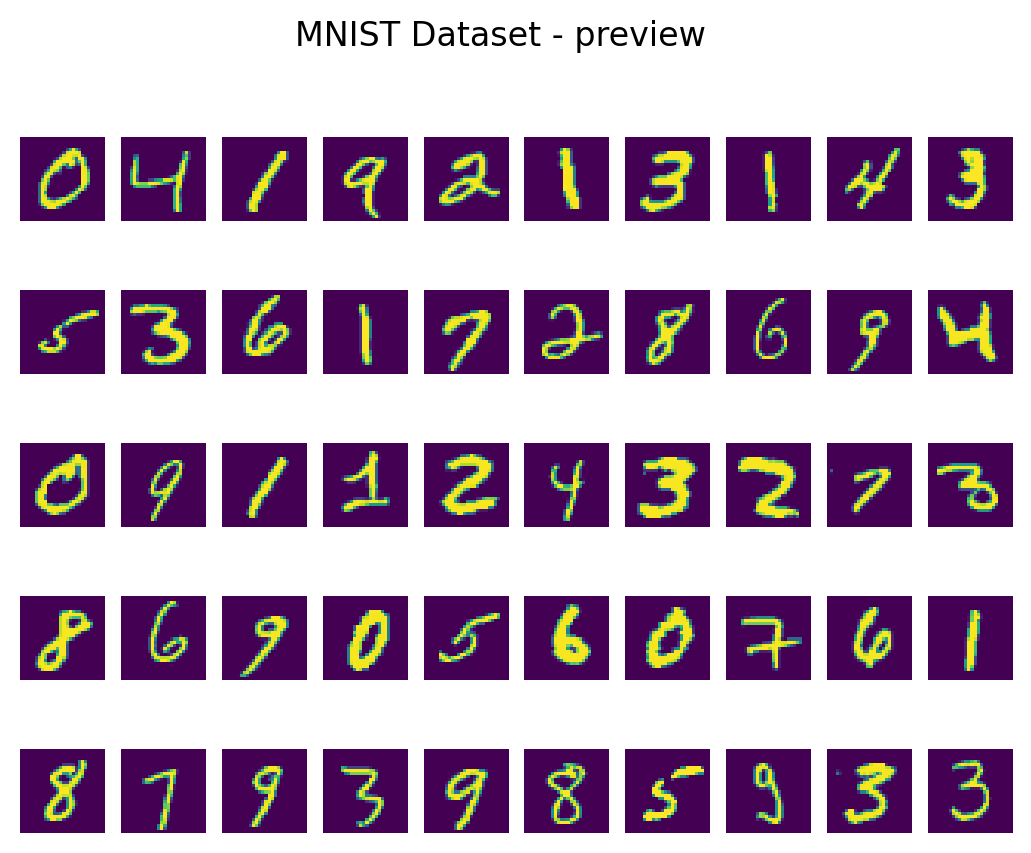

In [15]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

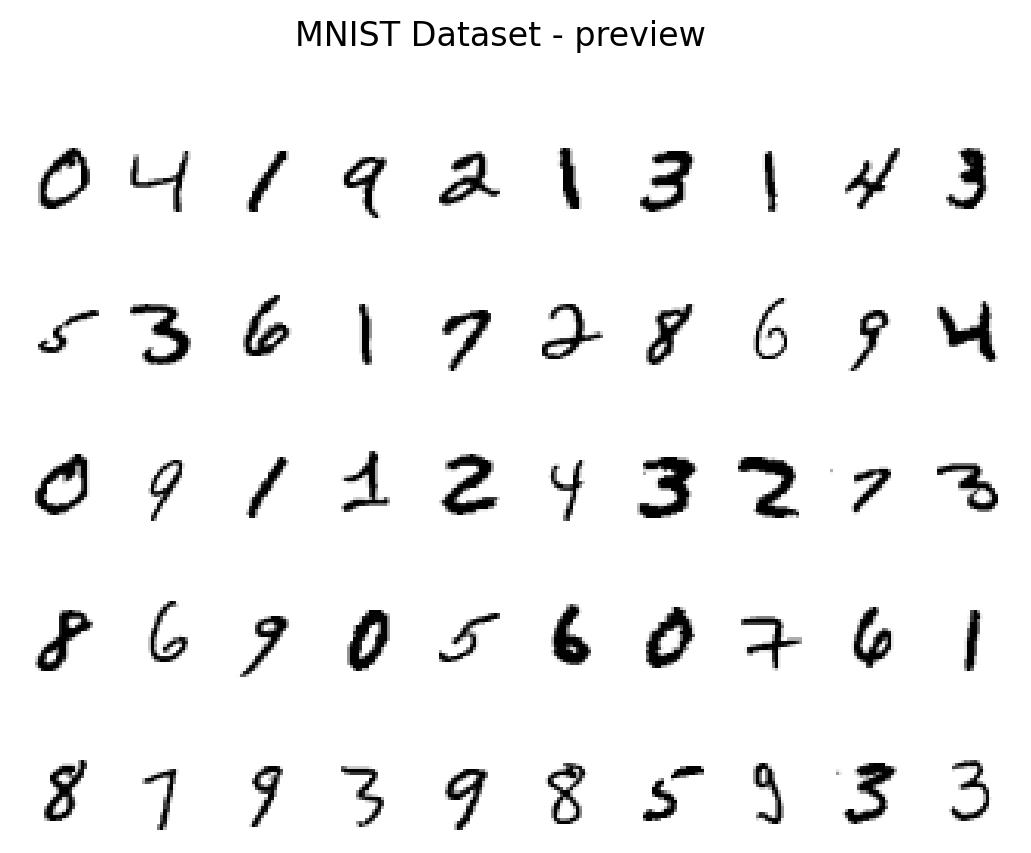

In [16]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

# Implementação da rede

In [18]:
trainCompTable = pd.DataFrame()
testCompTable = pd.DataFrame()
from google.colab import drive
drive.mount('/content/drive')
trainCompTable.to_csv('/content/drive/MyDrive/TG/train'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'_dropout.csv')
testCompTable.to_csv('/content/drive/MyDrive/TG/test'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'_dropout.csv')

MessageError: ignored

In [19]:
class LeNet5Dropout(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5Dropout, self).__init__()

        # feature extraction
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.drop1 = nn.Dropout2d(p=0.2)
        self.tanh1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.drop2 = nn.Dropout2d(p=0.2)
        self.tanh2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.drop3 = nn.Dropout2d(p=0.2)
        self.tanh3 = nn.Tanh()

        # fully connected
        self.linr1 = nn.Linear(in_features=120, out_features=84)
        self.drop4 = nn.Dropout2d(p=0.2)
        self.tanh4 = nn.Tanh()
        self.linr2 = nn.Linear(in_features=84, out_features=n_classes)


    def forward(self, x):

        # feature extraction
        x = self.conv1(x)
        x = self.drop1(x)
        x = self.tanh1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.drop2(x)
        x = self.tanh2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.drop3(x)
        x = self.tanh3(x)

        # fully connected
        x = torch.flatten(x, 1)
        x = self.linr1(x)
        x = self.drop4(x)
        x = self.tanh4(x)
        x = self.linr2(x)

        logits = x
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [20]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5Dropout(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, optimizer, _, (trainCompTable, testCompTable), (train_accuracy, valid_accuracy) = training_loop_with_hooks(model,
                                                                                criterion,
                                                                                optimizer,
                                                                                train_loader,
                                                                                valid_loader,
                                                                                N_EPOCHS,
                                                                                DEVICE,
                                                                                hook_every=SIZE_LOOP_TO_HOOK,
                                                                                hook_layers=False)

In [ ]:
train_accuracy.to_csv('/content/drive/MyDrive/TG/train_accuracy'+'_'+str(SIZE_LOOP_TO_HOOK)+"_"+str(N_EPOCHS)+'_dropout.csv')
valid_accuracy.to_csv('/content/drive/MyDrive/TG/test_accuracy'+'_'+str(SIZE_LOOP_TO_HOOK)+"_"+str(N_EPOCHS)+'_dropout.csv')

In [ ]:

trainCompTable.to_csv('/content/drive/MyDrive/TG/train'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'_dropout.csv')
testCompTable.to_csv('/content/drive/MyDrive/TG/test'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'_dropout.csv')